# Stereoisomer testing on ChiENN - diastereomere(meso) (multiple centers)

## Importing section

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import sys
sys.path.append("../../../../")

from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol
from ptgnn.features.chienn.mol_to_data import mol_to_data
from ptgnn.transform import edge_graph_transform, vertex_graph_transform

## Define SMILES strings

In [2]:
smiles_list = [
    "[C@](Br)(Cl)(F)[C@](Br)(Cl)(F)",
    "[C@@](Br)(Cl)(F)[C@](Br)(Cl)(F)",
    "[C@](Br)(Cl)(F)[C@@](Br)(Cl)(F)",
    "[C@@](Br)(Cl)(F)[C@@](Br)(Cl)(F)",
    
    "OC(=O)[C@](O)([H])[C@](O)([H])C(=O)O",
    "OC(=O)[C@@](O)([H])[C@](O)([H])C(=O)O",
    "OC(=O)[C@](O)([H])[C@@](O)([H])C(=O)O",
    "OC(=O)[C@@](O)([H])[C@@](O)([H])C(=O)O",
]

## Visualize and confirm stereomer classification (E/Z)

In [3]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

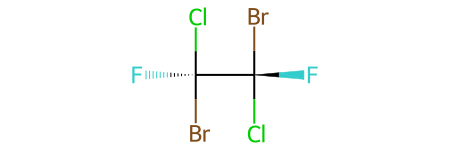

[(0, 'S'), (4, 'R')]


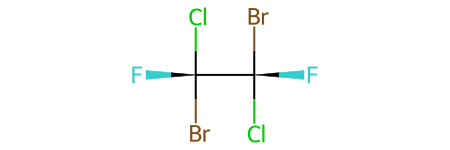

[(0, 'R'), (4, 'R')]


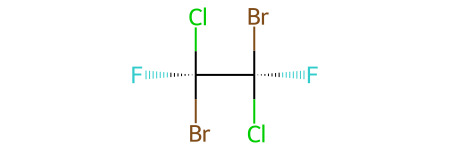

[(0, 'S'), (4, 'S')]


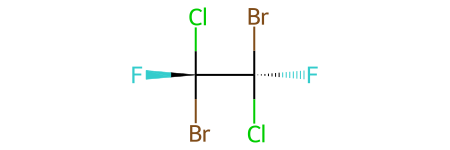

[(0, 'R'), (4, 'S')]


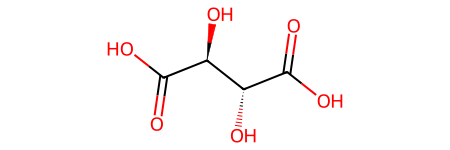

[(3, 'S'), (5, 'R')]
Bond 1 stereo: STEREONONE
Bond 7 stereo: STEREONONE


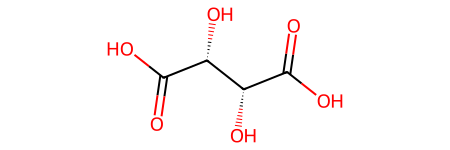

[(3, 'R'), (5, 'R')]
Bond 1 stereo: STEREONONE
Bond 7 stereo: STEREONONE


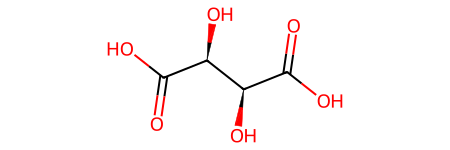

[(3, 'S'), (5, 'S')]
Bond 1 stereo: STEREONONE
Bond 7 stereo: STEREONONE


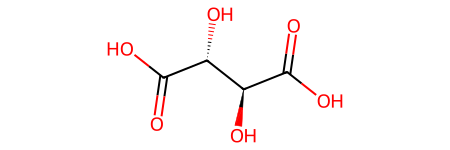

[(3, 'R'), (5, 'S')]
Bond 1 stereo: STEREONONE
Bond 7 stereo: STEREONONE


In [4]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph with ptree

In [5]:
# get molecules
mol_list = [
    smiles_to_3d_mol(
        smiles,
        max_number_of_attempts=100,
        max_number_of_atoms=100
    )
    for smiles in smiles_list
]

In [6]:
data_list = [
    mol_to_data(mol)
    for mol in mol_list
]

In [7]:
data_list = [
    edge_graph_transform(
        data,
        transformation_mode="permutation_tree",
        mol=mol,
        transformation_parameters={
            'k':  3,
            'tetrahedral_chiral': True,
            'chiral_center_selective': True,
            'chiral_center_select_potential': False,
        }
    )
    for data, mol in zip(data_list, mol_list)
]

In [8]:
for data in data_list:
    print(data)
    print(data.ptree)

Data(x=[14, 93], edge_index=[2, 38], edge_attr=[38, 57], pos=[14, 6], parallel_node_index=[14], circle_index=[14], ptree=[14], initial_map=[52], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=2, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1])
['{"S": [0, 1]}', '{"S": [1, 0, {"Z": [3, 7, 5]}]}', '{"S": [2, 3, {"Z": [0, 5, 7]}]}', '{"S": [3, 2]}', '{"S": [4, 5, {"Z": [0, 7, 3]}]}', '{"S": [5, 4]}', '{"S": [6, 7, {"Z": [0, 3, 5]}]}', '{"S": [7, 6, {"Z": [9, 13, 11]}]}', '{"S": [8, 9, {"Z": [6, 11, 13]}]}', '{"S": [9, 8]}', '{"S": [10, 11, {"Z": [6, 13, 9]}]}', '{"S": [11, 10]}', '{"S": [12, 13, {"Z": [6, 9, 11]}]}', '{"S": [13, 12]}']
Data(x=[14, 93], edge_index=[2, 38], edge_attr=[38, 57], pos=[14, 6], parallel_node_index=[14], circle_index=[14], ptree=[14], initial_map=[52], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=2, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1])
['{"S": [0, 1]}', '

## Create Model

In [9]:
from ptgnn.model.modules.ptree.advanced_tree_layer import AdvancedPermutationTreeLayer

k = 3

model = AdvancedPermutationTreeLayer(
    hidden_dim=93,
    k=k,
    batch_norm=False
)

## Create batches

In [10]:
from ptgnn.loading.collate import permutation_tree_collation

batch_list = [
    permutation_tree_collation([data])
    for data in data_list
]

In [12]:
# compare output
display(np.array(
    [
        [
            (batch_list[i].x == batch_list[j].x).all() if batch_list[i].x.shape == batch_list[j].x.shape else np.nan
            for j in range(len(batch_list))
        ]
        for i in range(len(batch_list))
    ]
))

array([[ 1.,  1.,  1.,  1., nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1., nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1., nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1., nan, nan, nan, nan],
       [nan, nan, nan, nan,  1.,  1.,  1.,  1.],
       [nan, nan, nan, nan,  1.,  1.,  1.,  1.],
       [nan, nan, nan, nan,  1.,  1.,  1.,  1.],
       [nan, nan, nan, nan,  1.,  1.,  1.,  1.]])

## Put batches through model

In [13]:
out_list = [
    model(batch)
    for batch in batch_list
]

## Compare batches

In [19]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all() if out_list[i].shape==out_list[j].shape else np.nan
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 1.,  0.,  0.,  1., nan, nan, nan, nan],
       [ 0.,  1.,  0.,  0., nan, nan, nan, nan],
       [ 0.,  0.,  1.,  0., nan, nan, nan, nan],
       [ 1.,  0.,  0.,  1., nan, nan, nan, nan],
       [nan, nan, nan, nan,  1.,  0.,  0.,  1.],
       [nan, nan, nan, nan,  0.,  1.,  0.,  0.],
       [nan, nan, nan, nan,  0.,  0.,  1.,  0.],
       [nan, nan, nan, nan,  1.,  0.,  0.,  1.]])

In [18]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True, False, False,  True, False, False, False, False],
       [False,  True, False, False, False, False, False, False],
       [False, False,  True, False, False, False, False, False],
       [ True, False, False,  True, False, False, False, False],
       [False, False, False, False,  True, False, False,  True],
       [False, False, False, False, False,  True, False, False],
       [False, False, False, False, False, False,  True, False],
       [False, False, False, False,  True, False, False,  True]])

In [17]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum() if batch_list[i].x.shape == batch_list[j].x.shape else np.nan
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[0.        , 0.57682198, 0.57682139, 0.        ,        nan,
               nan,        nan,        nan],
       [0.57682198, 0.        , 1.15364337, 0.57682198,        nan,
               nan,        nan,        nan],
       [0.57682139, 1.15364337, 0.        , 0.57682139,        nan,
               nan,        nan,        nan],
       [0.        , 0.57682198, 0.57682139, 0.        ,        nan,
               nan,        nan,        nan],
       [       nan,        nan,        nan,        nan, 0.        ,
        0.79547954, 0.79547942, 0.        ],
       [       nan,        nan,        nan,        nan, 0.79547954,
        0.        , 1.59095907, 0.79547954],
       [       nan,        nan,        nan,        nan, 0.79547942,
        1.59095907, 0.        , 0.79547942],
       [       nan,        nan,        nan,        nan, 0.        ,
        0.79547954, 0.79547942, 0.        ]])

1 = 4 in both, so meso detected as same element and enantiomer seperated